In [86]:
# import section
import cv2 #如果更加习惯用其他库比如说skimage就用自己最熟悉的，没有必要用opencv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [87]:
data_dir = 'data'
test_dir = os.path.join(data_dir, 'test.csv')
train_dir = os.path.join(data_dir, 'train.csv')

后面的代码为了演示如何读取图片并准备我们的training data，代码先把dataframe拆分储存为一个个的图片，然后示范了如何读取图片并标号label，再用sklearn split train and test data.


https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook#2.-Data-preparation
可以参照这个高赞的notebook 的data preparation部分，他是没有储存图片的，而是直接用的2d matrices (实际上是3d因为keras的cnn model只接受3d的图像数据, 所以他添加了一个)。通常来说如果我们有了所有图片的matrices data我们是不会去储存下来的（占用太多的空间，并且我们传进我们的model的数据也是matrices）。但是除开这个project以外的其他CV的project，所给的数据都是以图片的形式储存的，很少会有这种给一个dataframe的情况（这个proj的图片太简单了只包含了784 pixels，正常的图片包含了数百倍pixels，用dataframe储存所有不现实）



根据kaggle 给的data description:

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.


In [88]:
# 首先用pd读取一下看一下数据
train_df = pd.read_csv(train_dir)
display(train_df.shape)
# 根据介绍，一共有42000张图片，每张图片包含了28*28 = 784pixels

(42000, 785)

In [89]:
# 用你一张图片当作example来看看这个图片长啥样
first_img= train_df.iloc[0,:] # 第一张图
label, pixels = first_img[0], np.array(first_img[1:]) # 第一个column代表了label，后面的都是pixels
pixels = np.reshape(pixels, (28, 28)) # 将784的1d数组按照规矩转换成2d
display(label, pixels.shape)

1

(28, 28)

True

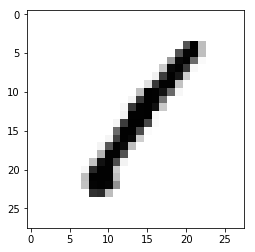

In [90]:
# 用matplotlib自带的imshow看一下这张图长啥样
plt.imshow(pixels, cmap="Greys")
# 用cv2储存下来
cv2.imwrite(os.path.join(data_dir, 'example1.jpg'), pixels)

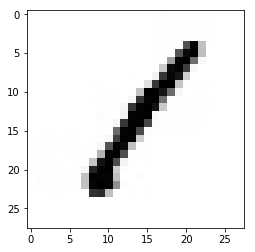

In [91]:
# 用cv2重新读取，检测我们图片是否正确储存了
check = cv2.imread(os.path.join(data_dir, 'example1.jpg'), cv2.IMREAD_GRAYSCALE) # Imread_greyscale 能够让我们读取grey images
plt.imshow(check, cmap='Greys')

In [92]:
# 确定了pattern以后，我们把所有的image都存下来
def store_image(image_path, pixels):
    pixels = np.reshape(pixels, (28, 28))
    cv2.imwrite(image_path, pixels)

In [93]:
# 建立10个文件夹来储存对应label的images
train_data_dir = os.path.join(data_dir, 'train_data')
os.mkdir(train_data_dir)
for i in range(10):
    # i represent labels 0 to 9
    os.mkdir(os.path.join(train_data_dir, str(i)))

In [94]:
# 将所有图片储存至对应文件夹
grps = train_df.groupby('label')
for name, group in grps:
    num_grp = len(group) #获取每个label有多少images
    target_path = os.path.join(train_data_dir, str(name)) # 储存对应的文件夹位置
    print('Adding {nums} photos to folder {path}'.format(nums=num_grp, path=target_path))
    for j in range(num_grp):
        image_path = os.path.join(target_path, str(j)+'.jpg')
        store_image(image_path, np.array(group.iloc[j, 1:]))
    print('done')

Adding 4132 photos to folder data\train_data\0
done
Adding 4684 photos to folder data\train_data\1
done
Adding 4177 photos to folder data\train_data\2
done
Adding 4351 photos to folder data\train_data\3
done
Adding 4072 photos to folder data\train_data\4
done
Adding 3795 photos to folder data\train_data\5
done
Adding 4137 photos to folder data\train_data\6
done
Adding 4401 photos to folder data\train_data\7
done
Adding 4063 photos to folder data\train_data\8
done
Adding 4188 photos to folder data\train_data\9
done


In [95]:
# reading images data and label them 
def read_img(imgpath):
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    img = img/255 #normalize, 理由见高赞notebook
    img = img.reshape(28, 28, 1) #增加一个以便于传入kera model
    return img

X = [] # store images
y = [] # store labels
for folder in os.listdir(train_data_dir):
    print('reading image labeled {x}'.format(x=folder))
    for img in os.listdir(folder_path):
        X.append(read_img(os.path.join(folder_path, img)))
        y.append(folder)
    print('done')

reading image labeled 0
done
reading image labeled 1
done
reading image labeled 2
done
reading image labeled 3
done
reading image labeled 4
done
reading image labeled 5
done
reading image labeled 6
done
reading image labeled 7
done
reading image labeled 8
done
reading image labeled 9
done


In [96]:
# one-hot encoding y labels
from keras.utils.np_utils import to_categorical
y = to_categorical(y, num_classes = 10)

In [97]:
# now, we are successfully import imgs data and their labels!
# However, always remember to check null values and plot some examples before get into modeling!